# Detecting disasters from Twitter data
### Ernesto Monroy (CID 01010397)
#### 31st of August 2020
#### Imperial College Business School: MSc in Business Analytics

This notebook is a complement to the submission of the Business Analytics Report of the same title

## Feature engineering

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 200
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


### Cleaning

In [5]:
import string
import re
from spellchecker import SpellChecker
spell = SpellChecker()
url_r = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
def clean_text(in_text):
    # Remove URLs
    url_pattern = re.compile(url_r)
    result = url_pattern.sub(r'', in_text)
    # Remove html
    html_pattern = re.compile('<.*?>')
    result = html_pattern.sub(r'', result)
    #Remove Emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    result = emoji_pattern.sub(r'', result)
    # Replace mentions
    mention_patter = re.compile(r'@\w+')
    result = mention_patter.sub(r'someone', result)
    # Remove punctuation
    result = result.translate(str.maketrans('', '', string.punctuation))
    # Remove hashtags??
    
    return result


df['clean'] = df['text'].str.lower().apply(clean_text)

### Spell Check

In [6]:
from spellchecker import SpellChecker
spell = SpellChecker()

def spell_check(in_tokens):
    corrected_text = []
    misspelled_words = spell.unknown(in_text.split())
    for word in in_text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)  

df['spell_checked'] = df['clean'].apply(spell_check)

NameError: name 'in_text' is not defined

### Tokenizing

At the moment we are tokenizing directly from the cleaned and not spell checked data because we dont know if the spell check will be good!

In [6]:
import nltk
#Change to lower case
df['tokens'] = df['clean']
#Splitting the sentence
df['tokens'] = df['tokens'].apply(lambda x : nltk.word_tokenize(x))

### POS Tags

In [7]:
df['pos'] = df['tokens'].apply(nltk.pos_tag)

### Remove stop words

In [8]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

def remove_stops(in_pos):
    out_pos = []
    for p in in_pos:
        if p[0] not in stops:
            out_pos += [p]
    return out_pos

df['pos'] = df['pos'].apply(remove_stops)

### Lemmatizing

In [9]:
from nltk import WordNetLemmatizer 
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

#Translate NLTK POS Tags to Wordnet POS Tags
tag_translate = {
    "J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV
}

def lemmatize(in_pos):
    #tag_translate.get(p[1][0], wordnet.NOUN)
    return [(lemmatizer.lemmatize(p[0],tag_translate.get(p[1][0], wordnet.NOUN)), p[1]) for p in in_pos]
        
df['lemma'] = df['pos'].apply(lemmatize)

### Vectorizing

First remerge to create text

In [10]:
df['final_text'] = df['lemma'].apply(lambda x: ' '.join([y[0] for y in x]))

# Test Train Splitting

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(df['final_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Due to the fact that the BERT model is trained on a separate notebook, we need to set the seed to guarantee the split of the data is identical.

In [12]:
from sklearn.model_selection import train_test_split
np.random.seed(43)
X_train, X_val, y_train, y_val = train_test_split(df['final_text'], df['target'], test_size=0.2)

# Model Training

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
def print_scores(y_true, y_predicted):
    print(f1_score(y_true, y_predicted))
    print(accuracy_score(y_true, y_predicted))

## Gaussian NB

In [15]:
from sklearn.naive_bayes import GaussianNB
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(X_train, y_train)
y_predict = GaussianNBModel.predict(X_val)
print_scores(y_val, y_predict)

0.6358792184724689
0.5961917268548916


## Bernoulli NB

In [56]:
from sklearn.naive_bayes import BernoulliNB
BernoulliNBModel = BernoulliNB(alpha=0.1)
BernoulliNBModel.fit(X_train, y_train)
y_predict = BernoulliNBModel.predict(X_val)
print_scores(y_val, y_predict)

0.7287191726332537
0.7760998030203545


## Multinomial NB

In [57]:
from sklearn.naive_bayes import MultinomialNB
MultinomialNBModel = MultinomialNB(alpha=0.1)
MultinomialNBModel.fit(X_train, y_train)
y_predict = MultinomialNBModel.predict(X_val)
print_scores(y_val, y_predict)

0.7223974763406938
0.7688772160210111


## Decision Tree

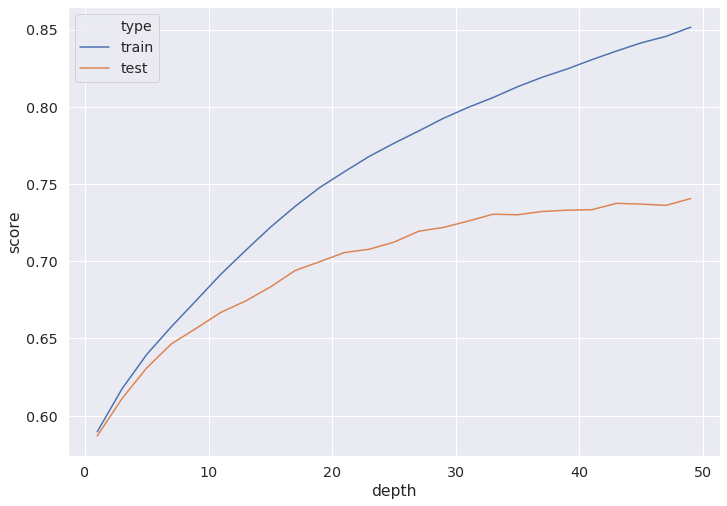

In [54]:
import seaborn as sns;
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from sklearn.model_selection import validation_curve
train_scoreNum, test_scoreNum = validation_curve(
                                DecisionTreeClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = range(1,50,2))

results=[{'type':'train','score':x[0],'depth':x[1]} for x in zip(np.mean(train_scoreNum, axis=1), range(1,50,2))]
results+=[{'type':'test','score':x[0],'depth':x[1]} for x in zip(np.mean(test_scoreNum, axis=1), range(1,50,2))]
validation_df = pd.DataFrame(results)

rcParams['figure.figsize'] = 11.7,8.27
sns.set(font_scale=1.3)
sns.lineplot(x='depth', y='score', hue ='type', data=validation_df)

In [55]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion= 'entropy', max_depth=45)
DecisionTreeClassifierModel.fit(X_train, y_train)
y_predict = DecisionTreeClassifierModel.predict(X_val)
print_scores(y_val, y_predict)

0.6960065199674003
0.7550886408404465


## SVM

In [58]:
from sklearn.svm import SVC
SVCModel = SVC()
SVCModel.fit(X_train, y_train)
y_predict = SVCModel.predict(X_val)
print_scores(y_val, y_predict)

0.7302977232924693
0.7977675640183848


## Gradient Boosting

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifierModel = GradientBoostingClassifier(loss = 'deviance',
    learning_rate = 0.01,
    n_estimators = 100,
    max_depth = 30)

model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print_scores(y_val, y_predict)

0.7004830917874396
0.7557452396585687


## KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifierModel = KNeighborsClassifier(n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute')
KNeighborsClassifierModel.fit(X_train, y_train)
y_predict = KNeighborsClassifierModel.predict(X_val)
print_scores(y_val, y_predict)

0.5402542372881356
0.7150361129349967


## Regression

In [63]:
from sklearn.linear_model import LogisticRegression
LogisticRegressionModel = LogisticRegression(penalty='l2', 
    solver='saga')  
LogisticRegressionModel.fit(X_train, y_train)
y_predict = LogisticRegressionModel.predict(X_val)
print_scores(y_val, y_predict)

0.7425249169435215
0.7964543663821405


/home/ernesto/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## SGD

In [64]:
from sklearn.linear_model import SGDClassifier
SGDClassifierModel = SGDClassifier(loss = 'hinge', 
  penalty = 'l1',
  learning_rate = 'optimal',
  max_iter=100)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print_scores(y_val, y_predict)

0.6969205834683955
0.7544320420223244


## Voting

In [68]:
from sklearn.ensemble import VotingClassifier

modelsNames = [('LogisticRegressionModel',LogisticRegressionModel),
               ('SGDClassifierModel',SGDClassifierModel),
               ('SVCModel',SVCModel),
               ('BernoulliNBModel',BernoulliNBModel),
               ('MultinomialNBModel',MultinomialNBModel)]

VotingClassifierModel = VotingClassifier(voting = 'hard',estimators= modelsNames)
VotingClassifierModel.fit(X_train, y_train)
y_predict = VotingClassifierModel.predict(X_val)
print_scores(y_val, y_predict)

/home/ernesto/snap/jupyter/common/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7417218543046358
0.7951411687458962


## Simple NN single input

In [91]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

model = keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2000, validation_split = 0.2, verbose=0)
y_predict = model.predict(X_val).flatten()
print_scores(y_val, y_predict.round(0))

0.7228915662650603
0.7734734077478661


## LSTM single input

### Create tokenizer

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(df['final_text'])
max_tokens = max(len(s) for s in tokenizer.texts_to_sequences(df['final_text']))

### Creating embeddings matrix

In [16]:
import numpy as np
embeddings_size = 100
lexicon_size = max(tokenizer.word_index.values()) + 1
embeddings = np.zeros((lexicon_size,embeddings_size))

with open('glove.twitter.27B.100d.txt', 'r', encoding="utf8") as f:
    for l in f:
        row = l.split()
        word = row[0]
        if word in tokenizer.word_index:
            embeddings[tokenizer.word_index[word]] = np.asarray(row[1:], dtype='float32')

### Create embeding matrices for test and train

In [17]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

#Convert to embedings sequences
X_train_sequences = sequence.pad_sequences(
        tokenizer.texts_to_sequences(X_train), maxlen=max_tokens
    )
X_val_sequences = sequence.pad_sequences(
        tokenizer.texts_to_sequences(X_val), maxlen=max_tokens
    )

y_train_categorical = to_categorical(y_train)

### Create the Network

In [25]:
from tensorflow.keras.layers import SpatialDropout1D, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D

LSTMModel = keras.Sequential()
LSTMModel.add(Input(shape=(max_tokens,)))
LSTMModel.add(
    Embedding(lexicon_size, embeddings_size, weights=[embeddings], input_length=max_tokens, trainable=False))
LSTMModel.add(SpatialDropout1D(0.2))
LSTMModel.add(Bidirectional(LSTM(128, return_sequences=True,dropout = 0.2)))
LSTMModel.add(Bidirectional(LSTM(128, return_sequences=True,dropout = 0.2)))
LSTMModel.add(Bidirectional(LSTM(128, return_sequences=True,dropout = 0.2)))
LSTMModel.add(Bidirectional(LSTM(128, return_sequences=True,dropout = 0.2)))
LSTMModel.add(SpatialDropout1D(0.8))
LSTMModel.add(Dense(256, activation='relu'))
LSTMModel.add(Dense(128, activation='relu'))
LSTMModel.add(Dense(2, activation='softmax'))

LSTMModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = LSTMModel.fit(X_train_sequences, y_train_categorical, epochs=100, validation_split = 0.2, verbose=0)

y_predict = LSTMModel.predict(X_val_sequences)
print_scores(y_val, np.argmax(y_predict, axis=1))
#Extra Dense and Dropout help

0.7425897035881436
0.783322390019698


## BERT

Due to the high computational requirements, the BERT model is implemented in an attached Jupyter Notebook